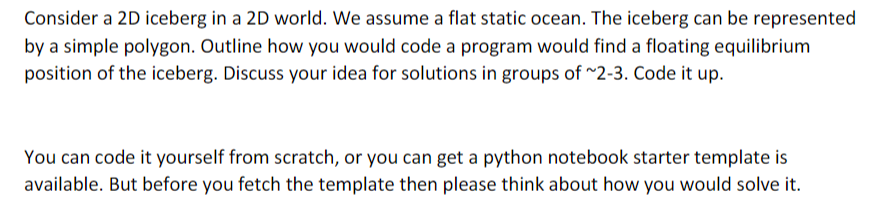

In [1]:
import numpy as np

In [77]:
# Assuming constant density of ice and water

iceberg = [(0, 0), (0, 100), (100, 100), (100, 0)]



def find_below_waterline(polygon, waterline):
    # loop through all the points in the polygon
    calc_polygon = []
    for i in range(len(polygon)):
        point = polygon[i%len(polygon)]
        next_point = polygon[(i+1) % len(polygon)]

        # add if the point is below the waterline
        if (point[1] < waterline):
            calc_polygon.append(point)

        # add intermediate point on waterline
        if (point[1] > waterline and next_point[1] < waterline) or (point[1] < waterline and next_point[1] > waterline):
            x = point[0] + (next_point[0] - point[0]) * (waterline - point[1]) / (next_point[1] - point[1])
            y = waterline
            calc_polygon.append((x, y))

    return calc_polygon


# function that finds the centroid of a polygon
def centroid(polygon):
    x = 0
    y = 0

    # calculate the centroid
    x,y = 0,0
    for point in polygon:
        x += point[0]
        y += point[1]
    
    return (x/len(polygon), y/len(polygon))

def PolyArea(polygon):
    x,y = np.array([p[0] for p in polygon]), np.array([p[1] for p in polygon])

    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def I_over_V(polygon, waterline):

    below_waterline = find_below_waterline(polygon, waterline)
    waterline_points = [p for p in below_waterline if p[1] == waterline]

    x1, x2 = waterline_points[0][0], waterline_points[1][0]
    
    mid = (x1 + x2)/2
    n = 0.01

    area = PolyArea(below_waterline)
    
    inte = np.sum([x**2 for x in np.arange(x1 - mid, x2 - mid, n)])/(area)*n

    return inte

def metacenter(iceberg, waterline):

    below_waterline = find_below_waterline(iceberg, waterline)

    return centroid(below_waterline)[1] + I_over_V(iceberg, waterline)


def is_stable(iceberg, waterline):
    # print(metacenter(iceberg, waterline), centroid(iceberg)[1])
    return centroid(iceberg)[1] < metacenter(iceberg, waterline)



for i in range(1, 100, 10):
    waterline = i
    print(waterline, is_stable(iceberg, waterline))









1 True
11 True
21 True
31 False
41 False
51 False
61 False
71 False
81 True
91 True
